In [42]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [43]:
data=pd.read_csv("dataset/trainJC.csv",sep=",")

data["date"]=pd.to_datetime(data["date"],format="%Y-%m-%d %H:%M:%S")
#data['substation'] = data['substation'].astype('category')
data["consumption"] = data["consumption"]
data.head()

data_test=pd.read_csv("dataset/test.csv",sep=",")
data_test["date"]=pd.to_datetime(data_test["date"],format="%Y-%m-%d %H:%M:%S")
#data_test['substation'] = data_test['substation'].astype('category')
data_test["consumption"] = data_test["consumption"]
#data_test.head()

In [44]:
data.info()
#data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244391 entries, 0 to 244390
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   substation   244391 non-null  object        
 1   date         244391 non-null  datetime64[ns]
 2   consumption  244391 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.6+ MB


In [45]:
# FILTRADO DE DATOS Y CREACION DE INDICES PARA ENTRENAMIENTO Y PRUEBA

df = data[data['substation'] == 'BUIN']
df = df.sort_values('date')
df.set_index('date', inplace=True)
del data

df_test = data_test[data_test['substation'] == 'BUIN']
df_test = df_test.sort_values('date')
df_test.set_index('date', inplace=True)
del data_test
gc.collect()

y = df['consumption']

In [46]:
# OBTIENE DATOS PARA ENTRENAMIENTO Y PRUEBAS

train = y.to_numpy()
test = df_test['consumption'].to_numpy()

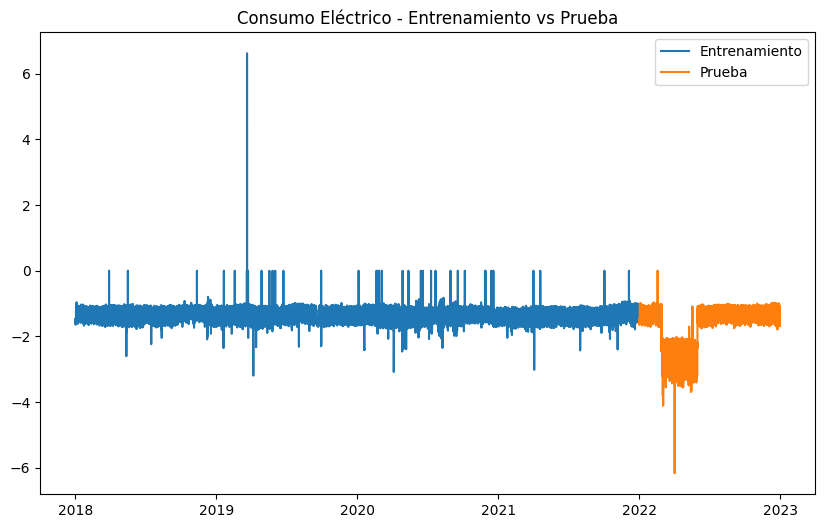

In [47]:
# VISUALIZACIÓN DE DATOS

plt.figure(figsize=(10, 6))
plt.plot(df.index,train, label='Entrenamiento')
plt.plot(df_test.index,test, label='Prueba')
plt.title('Consumo Eléctrico - Entrenamiento vs Prueba')
plt.legend()
plt.show()

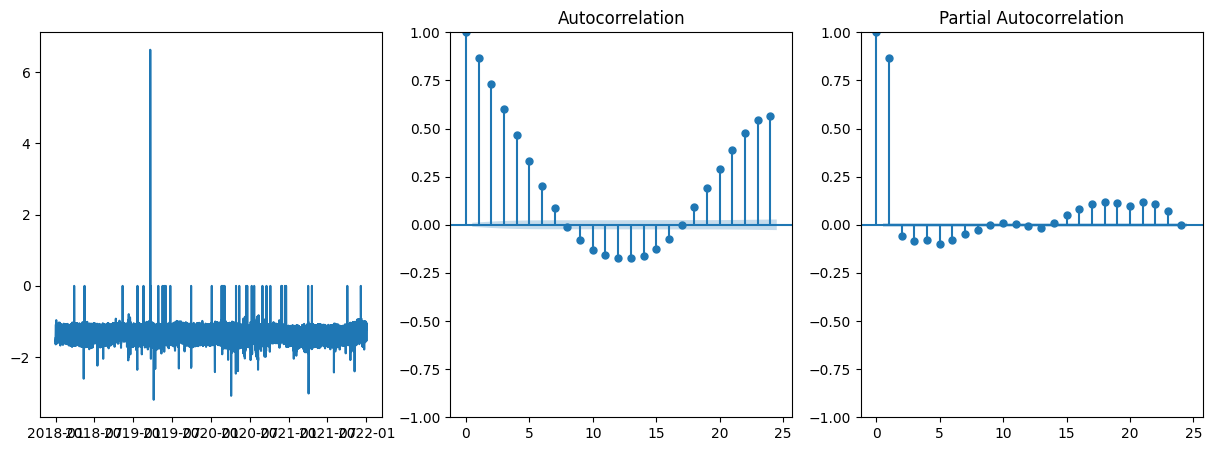

In [48]:
# AUTOCORRELACION 1 DIA

fig, axes=plt.subplots(1,3)
fig.set_size_inches(15,5)
axes[0].plot(df.index,y)
plot_acf(y,lags=24,ax=axes[1]);
plot_pacf(y,lags=24,ax=axes[2]);

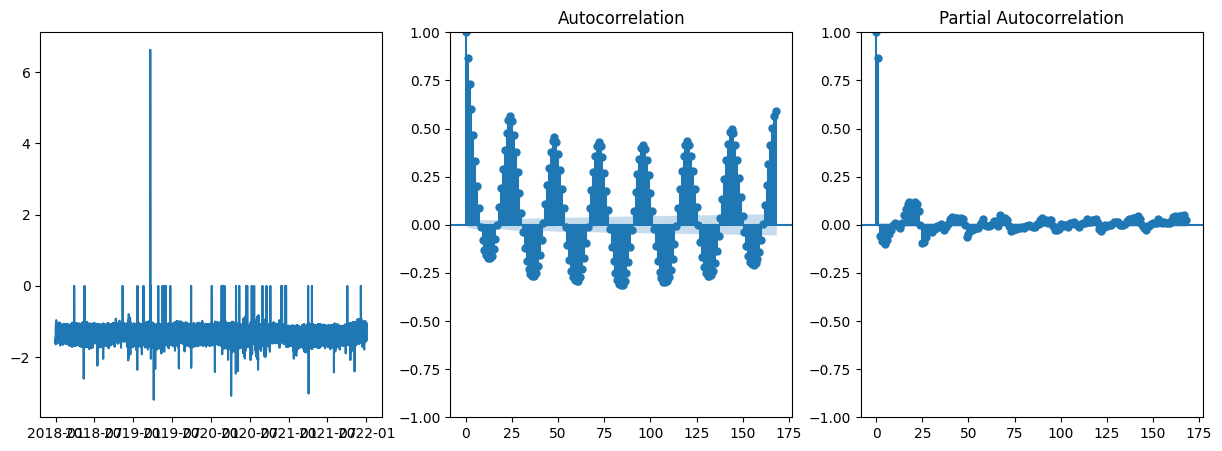

In [49]:
# AUTOCORRELACION 1 SEMANA

fig, axes=plt.subplots(1,3)
fig.set_size_inches(15,5)
axes[0].plot(df.index,y)
plot_acf(y,lags=168,ax=axes[1]);
plot_pacf(y,lags=168,ax=axes[2]);

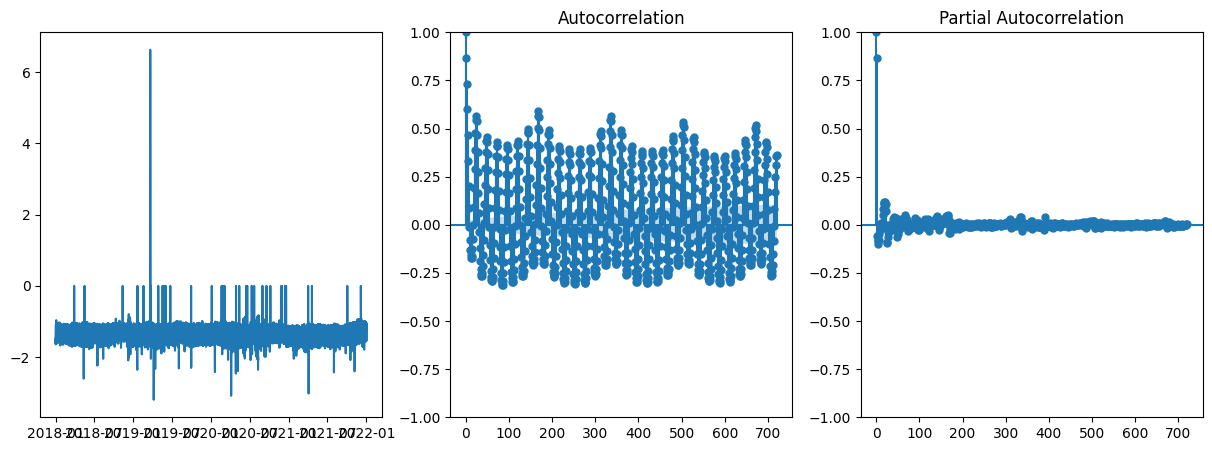

In [50]:
# AUTOCORRELACION 1 MES

fig, axes=plt.subplots(1,3)
fig.set_size_inches(15,5)
axes[0].plot(df.index,y)
plot_acf(y,lags=720,ax=axes[1]);
plot_pacf(y,lags=720,ax=axes[2]);

In [51]:
# IDENTIFICAR SI SERIE ES ESTACIONARIA

from statsmodels.tsa.stattools import adfuller
result = adfuller(train,maxlag=1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -51.491995
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [52]:
# ENTRENAMIENTO UTILIZANDO MODELO ARIMA

modelo=ARIMA(train,order=(24,0,2))
predictor=modelo.fit()
prediction_arima = predictor.predict(start=0, end=len(test) - 1, dynamic=False)
print("MSE",predictor.mse)
predictor.summary()

C:\Users\aris_\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 0.01339353261116303


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                34913
Model:                ARIMA(24, 0, 2)   Log Likelihood               25748.970
Date:                Tue, 24 Sep 2024   AIC                         -51441.940
Time:                        21:35:08   BIC                         -51205.043
Sample:                             0   HQIC                        -51366.473
                              - 34913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3620      0.009   -152.083      0.000      -1.380      -1.344
ar.L1          0.5722      0.055     10.497      0.000       0.465       0.679
ar.L2         -0.2802      0.067     -4.211      0.000      -0.411      -0.150
ar.L3          0.3796      0.031     12.072      0.000       0.318       0.441
ar.L4          0.0256      0.003      8.667      0.000       0.020       0.031
ar.L5         -0.0177      0.004     -4.606      0.000      -0.025      -0.010
ar.L6         -0.0254      0.004     -6.136      0.000      -0.034      -0.017
ar.L7         -0.0334      0.005     -6.776      0.000      -0.043      -0.024
ar.L8         -0.0376      0.005     -7.887      0.000      -0.047      -0.028
ar.L9         -0.0203      0.006     -3.549      0.000      -0.031      -0.009
ar.L10        -0.0010      0.005     -0.211      0.833      -0.010       0.008
ar.L11         0.0159      0.004      4.139      0.000       0.008       0.023
ar.L12         0.0230      0.004      5.485      0.000       0.015       0.031
ar.L13      1.926e-05      0.005      0.004      0.997      -0.010       0.010
ar.L14        -0.0150      0.006     -2.418      0.016      -0.027      -0.003
ar.L15        -0.0255      0.005     -4.690      0.000      -0.036      -0.015
ar.L16        -0.0253      0.006     -3.966      0.000      -0.038      -0.013
ar.L17        -0.0050      0.006     -0.886      0.376      -0.016       0.006
ar.L18         0.0136      0.005      2.692      0.007       0.004       0.024
ar.L19         0.0310      0.004      6.907      0.000       0.022       0.040
ar.L20         0.0090      0.006      1.634      0.102      -0.002       0.020
ar.L21         0.0425      0.005      9.026      0.000       0.033       0.052
ar.L22         0.0536      0.004     12.779      0.000       0.045       0.062
ar.L23         0.0756      0.004     19.331      0.000       0.068       0.083
ar.L24         0.0969      0.005     20.917      0.000       0.088       0.106
ma.L1          0.2234      0.054      4.102      0.000       0.117       0.330
ma.L2          0.4791      0.040     12.092      0.000       0.401       0.557
sigma2         0.0134   1.89e-05    708.142      0.000       0.013       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):         772970111.86
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             7.21
Prob(H) (two-sided):                  0.00   Kurtosis:                       731.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

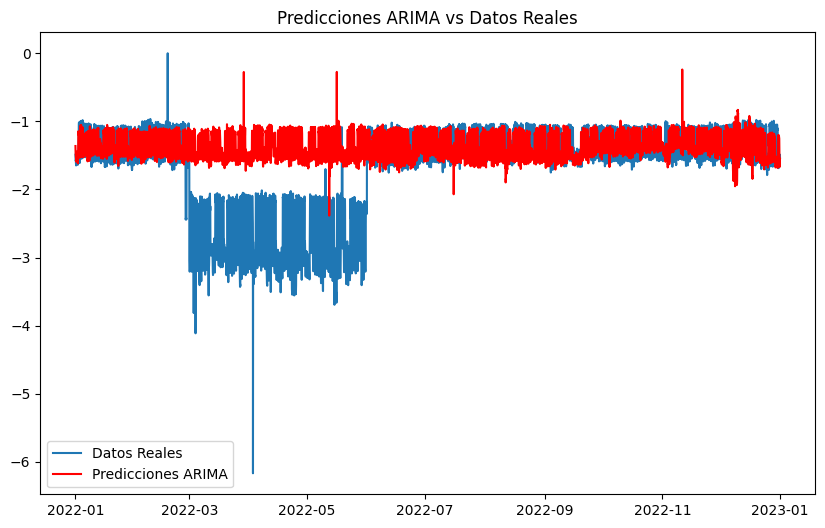

In [53]:
# VISUALIZACION PREDICCION ARIMA

plt.figure(figsize=(10, 6))
plt.plot(df_test.index, test, label='Datos Reales')
plt.plot(df_test.index, prediction_arima, label='Predicciones ARIMA', color='red')
plt.title('Predicciones ARIMA vs Datos Reales')
plt.legend()
plt.show()

In [54]:
# EVALUACION MODELO ARIMA

mse = mean_squared_error(test, prediction_arima)
mae = mean_absolute_error(test, prediction_arima)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')


Error Cuadrático Medio (MSE): 0.5908131843947921
Error Absoluto Medio (MAE): 0.5312028874955272
Raíz del Error Cuadrático Medio (RMSE): 0.7686437304725722


In [55]:
# ENTRENAMIENTO UTILIZANDO MODELO SARIMA

model = SARIMAX(train, 
                order=(1, 0, 1),         
                seasonal_order=(1, 0, 1, 24), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

predictor=model.fit()
prediction_sarima = predictor.predict(start=0, end=len(test) - 1, dynamic=False)
print("MSE",predictor.mse)
predictor.summary()


MSE 0.012770197564143335


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                34913
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood               26734.188
Date:                            Tue, 24 Sep 2024   AIC                         -53458.376
Time:                                    21:35:49   BIC                         -53416.077
Sample:                                         0   HQIC                        -53444.900
                                          - 34913                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8351      0.001    707.564      0.000       0.833       0.837
ma.L1         -0.1061      0.001    -88.524      0.000      -0.108      -0.104
ar.S.L24       0.9997      0.000   7082.997      0.000       0.999       1.000
ma.S.L24      -0.9482      0.001   -774.101      0.000      -0.951      -0.946
sigma2         0.0126   5.81e-06   2171.187      0.000       0.013       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):         848739779.17
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             8.07
Prob(H) (two-sided):                  0.00   Kurtosis:                       766.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

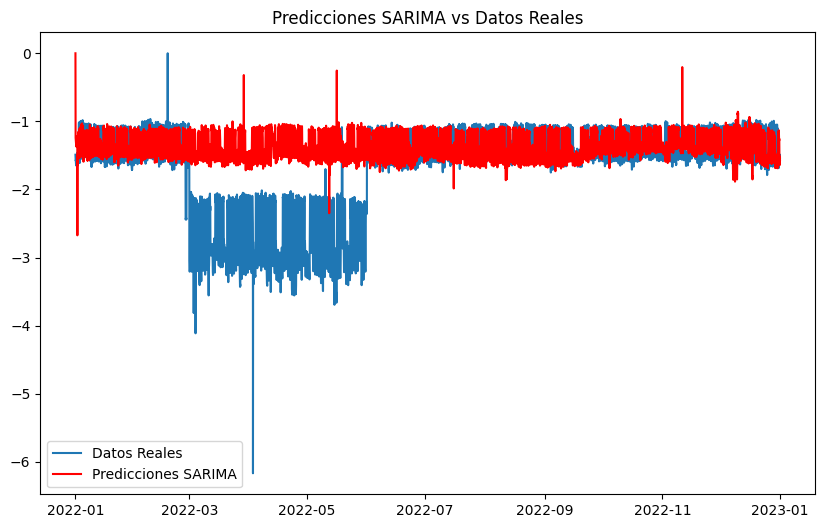

In [56]:
# VISUALIZACIÓN MODELO SARIMA

plt.figure(figsize=(10, 6))
plt.plot(df_test.index, test, label='Datos Reales')
plt.plot(df_test.index, prediction_sarima, label='Predicciones SARIMA', color='red')
plt.title('Predicciones SARIMA vs Datos Reales')
plt.legend()
plt.show()

In [57]:
# EVALUACION MODELO SARIMA

mse = mean_squared_error(test, prediction_sarima)
mae = mean_absolute_error(test, prediction_sarima)
rmse = np.sqrt(mse)

print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')

Error Cuadrático Medio (MSE): 0.593580290834584
Error Absoluto Medio (MAE): 0.53533649831954
Raíz del Error Cuadrático Medio (RMSE): 0.7704416206531056
